In [1]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({'axes.grid' : False})
import gseapy as gp
from matplotlib_venn import venn3
plt.rcParams['pdf.fonttype'] = 42


import sys
scr_path = '/nfs/team292/hm11/endo_GLND/starsolo/GLND/Thyroid/snippets'
sys.path.append(scr_path)
import singleCellFun as sf

import warnings
warnings.filterwarnings('ignore')

/home/jovyan/my-conda-envs/sc_Harm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/jovyan/my-conda-envs/sc_Harm/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# prep single cell data

In [2]:
# get single cell data
fname = '../../Thyrocytes/workingObj/adata_thy_ALL_harm_noStressEmb.h5ad'
adata = sc.read(fname)
sf.summaryTable(adata,['sample','karyotype','gender','donor','pcw'])

# add age groups
labels = ['9-10','11-13','14-20']
adata.obs['age_group'] = pd.cut(adata.obs['pcw'].astype(int), bins=[0, 10, 13, 20], include_lowest=True, labels=labels).rename('age_group')

[INFO] - total cells: 49853


In [3]:
# add celltype annotations
annot = pd.read_csv('../../Thyrocytes/workingObj/adata_thy_ALL_harm_annotations.csv', index_col=0)
adata.obs = pd.concat([adata.obs.loc[:,~adata.obs.columns.isin(annot.columns)], annot], axis=1)

In [4]:
def pp_norm(adata, celltype):
    subdata = adata[adata.obs['celltype'].isin(celltype)]
    sc.pp.filter_cells(subdata, min_genes=1000)
    sc.pp.filter_genes(subdata, min_cells=3)
    subdata.X = subdata.layers['counts'].copy()
    df = subdata.to_df()
    mat_norm = df.div(df.sum(axis=1), axis='index')
    print(f'df shape: {mat_norm.shape}')
    return mat_norm 

In [5]:
# norm counts by cells
pro_norm = pp_norm(adata, ['thy_TH_processing'])
lum_norm = pp_norm(adata, ['thy_Lumen-forming'])

df shape: (29434, 27588)
df shape: (13325, 26005)


In [6]:
# make mean per group
adata.obs['KA'] = adata.obs['karyotype'].astype(str)+'_'+adata.obs['age_group'].astype(str)

In [7]:
lum_norm_KA = pd.concat([lum_norm,adata.obs['KA']], axis=1)
pro_norm_KA = pd.concat([pro_norm,adata.obs['KA']], axis=1)

In [8]:
lum_mean = lum_norm_KA.groupby('KA').mean()
pro_mean = pro_norm_KA.groupby('KA').mean()

In [9]:
EXP_THRISH = 5E-6
lum_higenes = lum_mean.loc[:,lum_mean.max(axis=0) > EXP_THRISH].columns.tolist()
pro_higenes = pro_mean.loc[:,pro_mean.max(axis=0) > EXP_THRISH].columns.tolist()

hiexpgenes = list(set(lum_higenes) | set(pro_higenes))
len(hiexpgenes)

13822

In [10]:
# filter genes by min cells and %cells
higenes, groups = sf.getExpPercGroup(adata, ['karyotype','age_group','celltype'], min_cells = 20,  min_pct = 0.1)

HIgnees = list(set(hiexpgenes) & set(higenes))
len(HIgnees)

[INFO] 12 aggs using ['karyotype', 'age_group', 'celltype'] at min_cells=20,  min_pct=0.1. 12270 genes


12057

In [11]:
groups

['2n_11-13_thy_Cycling',
 '2n_11-13_thy_Lumen-forming',
 '2n_11-13_thy_TH_processing',
 '2n_14-20_thy_Cycling',
 '2n_14-20_thy_Lumen-forming',
 '2n_14-20_thy_TH_processing',
 'T21_11-13_thy_Cycling',
 'T21_11-13_thy_Lumen-forming',
 'T21_11-13_thy_TH_processing',
 'T21_14-20_thy_Cycling',
 'T21_14-20_thy_Lumen-forming',
 'T21_14-20_thy_TH_processing']

# export merged list 

In [2]:
logFC_THRESH = 0.2
FDR_THRESH = 0.05

fname1 = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
fname2 = '../data/allGenes_log2FC_splitbyCT.csv'
df = pd.concat([pd.read_csv(fname1), pd.read_csv(fname2)], axis=0)
print(f'{df.shape[0]} total genes')

sigup_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
sigup_genes = sigup_genes.sort_values('logFC',ascending=False)['geneSym'].unique().tolist()
print(f'{len(sigup_genes)} significant genes')

sigdn_genes = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
sigdn_genes = sigdn_genes.sort_values('logFC',ascending=False)['geneSym'].unique().tolist()
print(f'{len(sigdn_genes)} significant genes')


73708 total genes
146 significant genes
46 significant genes


In [15]:
tt = pd.read_csv(fname1)
tt[tt['geneSym'] == 'SLC5A5']

,Unnamed: 0,logFC,logCPM,F,PValue,FDR,ensID,geneSym,chr,isTF,isCSM,isCosmic,cosmicTier,tumourType,isTSG,comparison,isDEG,ischr21,group
643,ENSG00000105641,1.675009,7.366279,7.945002,0.013682,0.266157,ENSG00000105641,SLC5A5,chr19,False,False,False,NaN,NaN,False,fTFC1_14_20,False,False,nonDEG
19862,ENSG000001056411,-0.536832,5.279704,0.463780,0.510366,0.920111,ENSG00000105641,SLC5A5,chr19,False,False,False,NaN,NaN,False,fTFC1_11_13,False,False,nonDEG
25874,ENSG000001056412,1.834041,7.627789,12.548641,0.002981,0.236638,ENSG00000105641,SLC5A5,chr19,False,False,False,NaN,NaN,False,fTFC2_14_20,False,False,nonDEG
42727,ENSG000001056413,-0.685307,5.914622,0.734641,0.407532,0.914755,ENSG00000105641,SLC5A5,chr19,False,False,False,NaN,NaN,False,fTFC2_11_13,False,False,nonDEG


In [12]:
sigdn2export = df.loc[df['geneSym'].isin(sigdn_genes),['geneSym','chr']].drop_duplicates(subset='geneSym').reset_index(drop=True)
print(sigdn2export.shape[0])
sigdn2export.to_csv('./results/sigdn_genes.csv', index=False)

46


# hypergeometric analysis

In [12]:
logFC_THRESH = 0.2
FDR_THRESH = 0.1

In [13]:
fname1 = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
fname2 = '../data/allGenes_log2FC_splitbyCT.csv'
# df = pd.concat([pd.read_csv(fname1), pd.read_csv(fname2)], axis=0)
df = pd.read_csv(fname2)
print(f"current groups in analysis: {df['comparison'].unique()}")
# df = df[~df['comparison'].isin(['fTFC1_11_13','fTFC2_11_13'])] #focuse on late age group
# print(f"current groups in analysis: {df['comparison'].unique()}")
# print(f'{df.shape[0]} total genes')

sigup_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
sigup_genes = sigup_genes.sort_values('logFC',ascending=False)['geneSym'].unique().tolist()
print(f'up genes: {len(sigup_genes)} significant genes')

sigdn_genes = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
sigdn_genes = sigdn_genes.sort_values('logFC',ascending=False)['geneSym'].unique().tolist()
print(f'dn genes: {len(sigdn_genes)} significant genes')

current groups in analysis: ['fTFC1' 'fTFC2']
up genes: 180 significant genes
dn genes: 59 significant genes


In [14]:
print(len(set(HIgnees)&set(sigup_genes)))
print(len(set(HIgnees)&set(sigdn_genes)))

168
54


In [15]:
# hypergeometric analysis

def pathwayFisher(terms, genes, zon_genes, MIN_NUM_GENES = 10, QVAL_THRESH = 0.01, sort_by = 'qval', ascending = True):
    set2use = {k:v for k,v in terms.items() if len(set.intersection(set(zon_genes), set(v))) > MIN_NUM_GENES}
    # remove terms with disease|cancer
#     print(f'[INFO] remove terms with "disease|cancer|infection|carcinoma"')
#     set2use = {k:v for k,v in set2use.items() if not any(ext in k for ext in ['disease','cancer','infection','carcinoma'])}

    fisher_output = pd.DataFrame(columns=['pval','odds','genes','percent'])
    population_size = len(genes) #number of expressed genes
    sample_size =  len(zon_genes) #pathway genes in expressed list
    for path_name, path_genes in set2use.items():
        class_in_population = len(set.intersection(set(path_genes), set(genes))) #zonated genes found in expressed genes
        class_in_sample = len(set.intersection(set(zon_genes), set(path_genes))) #zonated genes in pathway
        
        output = sf.fisher_representation(sample_size, class_in_sample, population_size, class_in_population)
        fisher_output.loc[path_name, 'pval'] = output['pval'][1]
        fisher_output.loc[path_name, 'odds'] = output['odds'][1]
        fisher_output.loc[path_name, 'genes'] = list(set.intersection(set(genes), set(path_genes)))
        fisher_output.loc[path_name, 'percent'] = len(fisher_output.loc[path_name, 'genes']) / len(path_genes)
    from scipy import stats as st
    fisher_output['qval'] = st.false_discovery_control(fisher_output['pval'].to_numpy(dtype=np.number))
    zon_path = fisher_output[fisher_output['qval'] < QVAL_THRESH].sort_values(sort_by, ascending=ascending)
    print(f'sf.fisher_representation on: exp_genes {population_size}, zon_genes {sample_size}. zon_path {len(zon_path)} at MIN_NUM_GENES {MIN_NUM_GENES}, QVAL_THRESH {QVAL_THRESH}')
    return fisher_output, zon_path

In [16]:
# load terms
# kegg = gp.get_library('KEGG_2021_Human','Human')
go = gp.get_library('GO_Biological_Process_2023','Human')
# hall = gp.get_library('MSigDB_Hallmark_2020','Human')

In [17]:
terms = {**go}

In [18]:
print(len(HIgnees))
print(len(sigup_genes))
print(len(sigdn_genes))

12057
180
59


In [19]:
fisher_output, sigup_pathway = pathwayFisher(terms, HIgnees, sigup_genes, MIN_NUM_GENES = 3, QVAL_THRESH = 0.05, sort_by='percent', ascending=False)
sigup_pathway['term_clean'] = sigup_pathway.index.str.split('\s\(GO.', expand=True).get_level_values(0)
sigup_pathway = sigup_pathway.reset_index().set_index('term_clean')
sigup_pathway

sf.fisher_representation on: exp_genes 12057, zon_genes 180. zon_path 7 at MIN_NUM_GENES 3, QVAL_THRESH 0.05


,index,pval,odds,genes,percent,qval
term_clean,,,,,,
Peptidyl-Threonine Phosphorylation,Peptidyl-Threonine Phosphorylation (GO:0018107),0.000863,7.512381,"[DYRK2, OXSR1, TBK1, GPI, DYRK4, DYRK1A, ATF2,...",0.862069,0.017256
Peptidyl-Threonine Modification,Peptidyl-Threonine Modification (GO:0018210),0.001334,6.758286,"[DYRK2, OXSR1, TBK1, GPI, DYRK4, DYRK1A, ATF2,...",0.833333,0.020011
Cell Junction Organization,Cell Junction Organization (GO:0034330),0.001949,8.412642,"[CTNND2, TJP3, PPFIA1, TJP2, SH3BP1, MARVELD2,...",0.580645,0.023384
Protein Homooligomerization,Protein Homooligomerization (GO:0051260),0.004923,4.889441,"[ECT2, ZNF746, THG1L, IKZF4, SHMT1, CBY1, CLU,...",0.573643,0.042195
Cell-Cell Junction Organization,Cell-Cell Junction Organization (GO:0045216),0.002386,7.916444,"[CTNND2, CDH12, TJP3, CDH1, TJP2, MARVELD2, TL...",0.558824,0.023860
Interferon-Mediated Signaling Pathway,Interferon-Mediated Signaling Pathway (GO:0140...,0.000341,14.184211,"[IFNAR2, TBK1, TRAF3, IFNGR2, STAT2, IFITM2, M...",0.469388,0.010221
Cellular Response To Virus,Cellular Response To Virus (GO:0098586),0.000002,19.46798,"[EIF5A, IRF3, IFNAR2, IFI6, IFNGR2, RIOK3, IL1...",0.421875,0.000139


In [20]:
def makeBins(df, n_bins=4, roundup10=False):
    import pandas as pd
    import numpy as np
    import math
    
    # Calculate the ceiling of the maximum value
    max_value = math.ceil(df.max())

    if roundup10:
        max_value = int(math.ceil(max_value / 10.0)) * 10
    # Generate integer bin edges from 0 to the ceiling of the maximum value
    bin_edges = np.linspace(0, max_value, num=n_bins).astype(int)  # 4 bins require 5 edges
    print(max_value)

    # Ensure bin edges are unique integers (avoid duplicates due to rounding)
    bin_edges = np.unique(bin_edges)

    # Use pd.cut to bin the data
    data_groups = pd.cut(df, bins=bin_edges, include_lowest=True)

    # Map bins to intervals as strings with integer bounds
    grouped_data = pd.DataFrame({
        'Value': df,
    #     'Group': data_groups.map(lambda x: f"[{int(x.left)}, {int(x.right)})" if x.right != bin_edges[-1] else f"[{int(x.left)}, {int(x.right)}]")
        'Group': data_groups.map(lambda x: f"{int(x.right)}")
    })
    print(f"n_bins: {n_bins-1}")
    print(f"bins  : {list(np.sort(grouped_data['Group'].unique()))}")
    return grouped_data

20
n_bins: 4
bins  : ['10', '15', '20', '5']


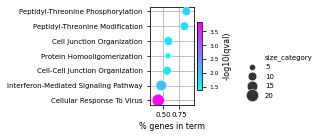

In [21]:
TOP_N = 15
df2plot = sigup_pathway.sort_values('percent', ascending=False).reset_index()
df2plot['-log10(qval)'] = -np.log10(df2plot['qval'])
norm = plt.Normalize(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max())
sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
sm.set_array([])

d2plot = df2plot.iloc[:TOP_N,:]
grouped_data = makeBins(d2plot['odds'], n_bins=5)
d2plot['size_category'] = grouped_data['Group']

# map bins to size
orig_bins  = np.append(0, d2plot['size_category'].astype(int).sort_values().unique())
mapped_bins= np.interp(orig_bins, (orig_bins.min(), orig_bins.max()), (0, 150))

fig, ax = plt.subplots(1,1, figsize=(1,1.8))
# fig, ax = plt.subplots(1,1, figsize=(1,2.5))
ax.grid(True)
g = sns.scatterplot(data=d2plot, x='percent', y='term_clean',
                    hue='-log10(qval)', palette='cool', ax=ax, zorder=3,
                    hue_norm=(d2plot['-log10(qval)'].min(), d2plot['-log10(qval)'].max()),
                    size='size_category',
                    sizes=dict(zip(list(orig_bins.astype(str)),mapped_bins)),
                    linewidth=0.5)

# Remove only hue legend, keep size legend
handles, labels = g.get_legend_handles_labels()
size_idx = [i for i,v in enumerate(labels) if v=='size_category'][0]
size_handles = handles[size_idx:]
size_labels = labels[size_idx:]

plt.legend(
    size_handles, 
    size_labels, 
    bbox_to_anchor=(2,0), 
    loc='lower left',
    frameon=False,
    fontsize=7,
)
delta = 0.1
ax.set_xlim(np.floor(np.min(ax.get_xlim())*100)/100 - delta,np.ceil(np.max(ax.get_xlim())*100)/100 + delta)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7); #7
ax.set_ylabel('', fontsize=6);
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7); #7
ax.set_xlabel('% genes in term', fontsize=8);
cbar = fig.colorbar(sm, label='-log10(qval)', shrink=0.7, aspect=20*0.7, ax=ax)
cbar.ax.tick_params(labelsize=6) 
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), size=8) ;

plt.tight_layout()
plt.savefig('figures/T21up_hypergeo_second_analysis_only.pdf', dpi=300)

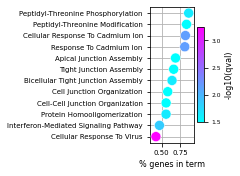

In [21]:
df2plot = sigup_pathway.sort_values('percent', ascending=False).reset_index()
df2plot['-log10(qval)'] = -np.log10(df2plot['qval'])
norm = plt.Normalize(df2plot['-log10(qval)'].min(), df2plot['-log10(qval)'].max())
sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
sm.set_array([])

fig, ax = plt.subplots(1,1, figsize=(1,2.5))
ax.grid(True)
sns.scatterplot(data=df2plot, x='percent', y='term_clean', hue='-log10(qval)', palette='cool', ax=ax, zorder=3, s=100, linewidth=0.5)
delta = 0.05
ax.set_xlim(np.floor(np.min(ax.get_xlim())*100)/100 - delta,np.ceil(np.max(ax.get_xlim())*100)/100 + delta)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7); #7
ax.set_ylabel('', fontsize=6);
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7); #7
ax.set_xlabel('% genes in term', fontsize=8);
ax.get_legend().remove()
cbar = fig.colorbar(sm, label='-log10(qval)', shrink=0.7, aspect=20*0.7, ax=ax)
cbar.ax.tick_params(labelsize=6) 
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), size=8) ;
plt.tight_layout()
plt.savefig('figures/T21up_hypergeo.pdf', dpi=300)

In [22]:
fisher_output, sigdn_pathway = pathwayFisher(terms, HIgnees, sigdn_genes, MIN_NUM_GENES = 3, QVAL_THRESH = 0.05, sort_by='percent', ascending=False)
# sigdn_pathway['term_clean'] = sigdn_pathway.index.str.split('\s\(GO.', expand=True).get_level_values(0)
# sigdn_pathway = sigdn_pathway.reset_index().set_index('term_clean')
# fisher_output
sigdn_pathway

sf.fisher_representation on: exp_genes 12057, zon_genes 59. zon_path 0 at MIN_NUM_GENES 3, QVAL_THRESH 0.05


,pval,odds,genes,percent,qval


# pbulk analysis

In [23]:
logFC_THRESH = 0.2
FDR_THRESH = 0.1

In [24]:
# expression of enriched genes
# fname1 = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
fname2 = '../data/allGenes_log2FC_splitbyCT.csv'
# df = pd.concat([pd.read_csv(fname1), pd.read_csv(fname2)], axis=0)
df = pd.read_csv(fname2)
print(f'{df.shape[0]} total genes')

union_sigup = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
union_sigup_unique = union_sigup.sort_values(by='logFC', ascending=False).drop_duplicates(subset='geneSym', keep='first')
print(f'up regulated {len(union_sigup_unique)}')

union_sigdn = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)]
union_sigdn_unique = union_sigdn.sort_values(by='logFC', ascending=False).drop_duplicates(subset='geneSym', keep='first')
print(f'dn regulated {len(union_sigdn_unique)}')

24479 total genes
up regulated 180
dn regulated 59


all trems included!


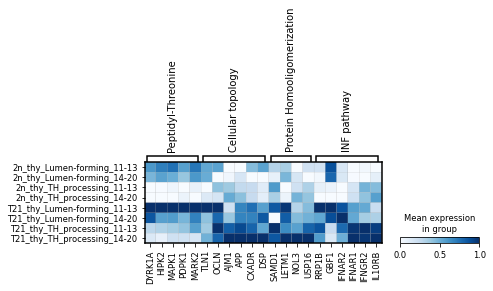

In [25]:
# get terms from hypergeometric analysis
dd = {}
for term in sigup_pathway.index:
    genes = sigup_pathway.loc[term, 'genes']
    dd[term] = list(set(union_sigup['geneSym']) & set(genes))

# merge keys and values of hypergeometric output
term_groups = {'Peptidyl-Threonine' : ['Peptidyl-Threonine Phosphorylation','Peptidyl-Threonine Modification'],
               'Cellular topology': ['Cell Junction Organization','Cell-Cell Junction Organization'],
               'Protein Homooligomerization': ['Protein Homooligomerization'],
               'INF pathway': ['Interferon-Mediated Signaling Pathway','Cellular Response To Virus']
              }

# check if all terms included in 'term_groups'
s1 = set(dd.keys())
s2 = set([x for xs in term_groups.values() for x in xs])
if (len(s2-s1)) & (len(s1-s2)) is 0 : print('all trems included!')
    
# prep for plot
dict2plot = {}
for k,v in term_groups.items():
    gg = [dd.get(key, None) for key in v]
    gg = [x for xs in gg for x in xs]
    gg = list(np.unique(gg))
    dict2plot[k] = gg

# plot genes in single cell data [basedon dict2plot ordered manually]
markers = {'Peptidyl-Threonine': ['DYRK1A', 'HIPK2', 'MAPK1','PDPK1', 'MARK2'],
             'Cellular topology': ['TLN1','OCLN', 'AJM1', 'APP', 'CXADR', 'DSP'],
             'Protein Homooligomerization': ['SAMD1', 'LETM1', 'NOL3', 'USP16'],
             'INF pathway': ['RRP1B', 'GBF1', 'IFNAR2', 'IFNAR1', 'IFNGR2', 'IL10RB']}
bdata = adata[adata.obs['celltype'].isin(['thy_TH_processing', 'thy_Lumen-forming'])]


In [59]:
temp = pd.DataFrame([item for sublist in markers.values() for item in sublist], columns=['gene'])
temp = sf.addChrInfo(temp, geneColumn='gene')
temp[temp['chr'] == 'chr21']

,gene,chr,ensID
0,DYRK1A,chr21,ENSG00000157540
8,APP,chr21,ENSG00000142192
9,CXADR,chr21,ENSG00000154639
14,USP16,chr21,ENSG00000156256
15,RRP1B,chr21,ENSG00000160208
17,IFNAR2,chr21,ENSG00000159110
18,IFNAR1,chr21,ENSG00000142166
19,IFNGR2,chr21,ENSG00000159128
20,IL10RB,chr21,ENSG00000243646


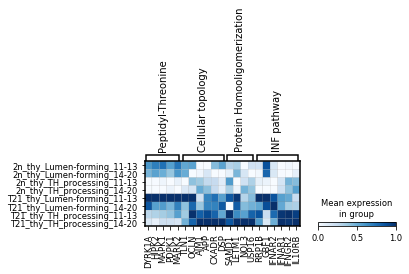

In [28]:
sc.pl.matrixplot(bdata, var_names=markers, groupby=['karyotype','celltype','age_group'], standard_scale='var',
                 cmap='Blues', figsize=(4.5, 1.2), save="go_genes_second_analysis.pdf")

# GO plot with marsilea

In [269]:
import marsilea as ma
import marsilea.plotter as mp
import matplotlib as mpl

In [270]:
long_list = [item for sublist in dict2plot.values() for item in sublist]

exp = bdata[:, long_list]
mm = pd.concat([exp.to_df(), bdata.obs[['karyotype','celltype','age_group']]], axis=1).groupby(['karyotype','celltype','age_group']).mean().reset_index()
metadata = mm[['karyotype','celltype','age_group']]
data = mm.loc[:,mm.columns.isin(set(mm.columns)-set(metadata.columns))] #keep the order of longlist

In [271]:
terms, markers = [], []
for c, ms in dict2plot.items():
    terms += [c] * len(ms)
    markers += ms
uni_terms = list(dict2plot.keys())

In [272]:
metadata = metadata.replace({'thy_Lumen-forming':'fTFC2', 'thy_TH_processing':'fTFC1'})
metadata['age_group'] = metadata['age_group'].astype(str)+' PCW'
side_labels = metadata[['celltype','age_group']].apply(lambda r: ' | '.join(r), axis=1)
kar_labels = list(metadata['karyotype'])

In [314]:
dict2plot

{'Peptidyl-Threonine': ['DYRK1A', 'HIPK2', 'MAPK1', 'MARK2', 'PDPK1'],
 'Cellular topology': ['AJM1', 'APP', 'CXADR', 'DSP', 'OCLN', 'TLN1'],
 'Protein Homooligomerization': ['LETM1', 'NOL3', 'SAMD1', 'USP16'],
 'INF pathway': ['GBF1', 'IFNAR1', 'IFNAR2', 'IFNGR2', 'IL10RB', 'RRP1B']}

In [313]:
pd.Series(terms).unique().tolist()

['Peptidyl-Threonine',
 'Cellular topology',
 'Protein Homooligomerization',
 'INF pathway']

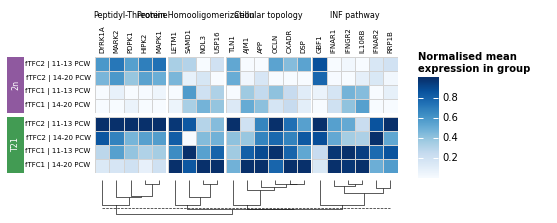

In [325]:
h, w = data.shape
data = (data - data. min()) / (data. max() - data. min())
m = ma.Heatmap(data,
    height=h / 5,
    width=w / 5,
    cmap="Blues",
    linewidth=0.5,
    linecolor="lightgray",
    label="Normalised mean\nexpression in group",
)
m.add_top(mp.Labels(long_list, fontsize=7), pad=0.05)
m.group_cols(terms, spacing=0.005, order=list(dict2plot.keys()))
m.add_top(mp.Chunk(list(dict2plot.keys()), rotation=0, fontsize=8))
m.add_dendrogram("bottom", pad=0.1, add_base=True)
m.group_rows(kar_labels, spacing=0.04)
m.add_left(mp.Labels(side_labels, fontsize=7), pad=0.05)
m.add_left(mp.Chunk(list(np.unique(kar_labels)), fontsize=8, fill_colors=['#8F599F','#429B53']))

m.add_legends()
m.render()
# plt.savefig('figures/terms_heatmap.pdf', dpi=300)

# check if the two cell type show same behaviour 

In [12]:
logFC_THRESH = 0.2
FDR_THRESH = 0.05

In [13]:
fname = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

sig_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)] #upregulated only
df2plot1 = sig_genes[sig_genes['comparison'].isin(['fTFC1_11_13','fTFC2_11_13'])] #celltype
print(f'{df2plot1.shape[0]} significant genes')

df2plot2 = sig_genes[sig_genes['comparison'].isin(['fTFC1_14_20','fTFC2_14_20'])] #celltype
print(f'{df2plot2.shape[0]} significant genes')

# time insensitive analysis
fname = '../data/allGenes_log2FC_splitbyCT.csv'
T21df = pd.read_csv(fname)
T21sig_genes = T21df[(T21df['logFC'] > logFC_THRESH) & (T21df['FDR'] < FDR_THRESH)] #upregulated only
print(f'{T21sig_genes.shape[0]} significant genes')

49229 total genes
12 significant genes
108 significant genes
186 significant genes


In [261]:
def getUpDn(df, logFC_THRESH=0.2, FDR_THRESH=0.05):
    up = df[(df['logFC'] >  logFC_THRESH) & (df['FDR'] < FDR_THRESH)] 
    dn = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)] 
    print(f"up: {up.shape[0]}, dn: {dn.shape[0]}")
    return up, dn

def getIntersects(up,dn):
    output={}
    output['up'] = {}
    output['dn'] = {}
    a = set(up.loc[up['celltype'].isin(['fTFC1']), 'geneSym'])
    b = set(up.loc[up['celltype'].isin(['fTFC2']), 'geneSym'])
    print(f"up: fTFC1: {len(a)}; fTFC2: {len(b)}; intersect: {len(a&b)}")
    output['up']['fTFC1'] = len(a)
    output['up']['fTFC2'] = len(b)
    output['up']['intersect'] = len((a&b))
    a = set(dn.loc[dn['celltype'].isin(['fTFC1']), 'geneSym'])
    b = set(dn.loc[dn['celltype'].isin(['fTFC2']), 'geneSym'])
    print(f"dn: fTFC1: {len(a)}; fTFC2: {len(b)}; intersect: {len(a&b)}")
    output['dn']['fTFC1'] = len(a)
    output['dn']['fTFC2'] = len(b)
    output['dn']['intersect'] = len((a&b))
    return output

def getIntersectsLists(up,dn):
    output={}
    output['up'] = {}
    output['dn'] = {}
    a = set(up.loc[up['celltype'].isin(['fTFC1']), 'geneSym'])
    b = set(up.loc[up['celltype'].isin(['fTFC2']), 'geneSym'])
    print(f"up: fTFC1: {len(a)}; fTFC2: {len(b)}; intersect: {len(a&b)}")
    output['up']['fTFC1'] = list(a)
    output['up']['fTFC2'] = list(b)
    output['up']['intersect'] = list(a&b)
    a = set(dn.loc[dn['celltype'].isin(['fTFC1']), 'geneSym'])
    b = set(dn.loc[dn['celltype'].isin(['fTFC2']), 'geneSym'])
    print(f"dn: fTFC1: {len(a)}; fTFC2: {len(b)}; intersect: {len(a&b)}")
    output['dn']['fTFC1'] = list(a)
    output['dn']['fTFC2'] = list(b)
    output['dn']['intersect'] = list(a&b)
    return output

In [272]:
fname = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
df = pd.read_csv(fname)
print(f"{df['comparison'].unique()}")
tmp = df['comparison'].str.split('_',1, expand=True).rename(columns={0:'celltype', 1:'age_group'})
df = pd.concat([df, tmp], axis=1)

AGE_GROUP = '11_13'
print(f"\nAGE_GROUP: {AGE_GROUP}")
df2test = df[df['age_group'].isin([AGE_GROUP])]
up, dn = getUpDn(df2test, logFC_THRESH=0.2, FDR_THRESH=0.05)
# output = getIntersects(up,dn)
# output1 = pd.DataFrame.from_dict(output)
output1 = getIntersectsLists(up,dn)
# output1['age_group'] = AGE_GROUP

AGE_GROUP = '14_20'
print(f"\nAGE_GROUP: {AGE_GROUP}")
df2test = df[df['age_group'].isin([AGE_GROUP])]
up, dn = getUpDn(df2test, logFC_THRESH=0.2, FDR_THRESH=0.05)
# output = getIntersects(up,dn)
# output2 = pd.DataFrame.from_dict(output)
output2 = getIntersectsLists(up,dn)
# output2['age_group'] = AGE_GROUP

fname = '../data/allGenes_log2FC_splitbyCT.csv'
df = pd.read_csv(fname)
print(f"\n{df['comparison'].unique()}")

df['celltype'] = df['comparison']
up, dn = getUpDn(df, logFC_THRESH=0.2, FDR_THRESH=0.05)
# output3 = getIntersects(up,dn)
output3 = getIntersectsLists(up,dn)


['fTFC1_14_20' 'fTFC1_11_13' 'fTFC2_14_20' 'fTFC2_11_13']

AGE_GROUP: 11_13
up: 12, dn: 0
up: fTFC1: 12; fTFC2: 0; intersect: 0
dn: fTFC1: 0; fTFC2: 0; intersect: 0

AGE_GROUP: 14_20
up: 108, dn: 29
up: fTFC1: 80; fTFC2: 28; intersect: 23
dn: fTFC1: 22; fTFC2: 7; intersect: 5

['fTFC1' 'fTFC2']
up: 186, dn: 28
up: fTFC1: 124; fTFC2: 62; intersect: 56
dn: fTFC1: 20; fTFC2: 8; intersect: 1


In [288]:
def getStat(list_A_input, list_B_input):
    from scipy.stats import fisher_exact 
    #code from Erick
    # Define your gene lists
    list_A = set(list_A_input)
    list_B = set(list_B_input)
    universe = set(list_A_input).union(set(list_B_input))

    # Calculate the contingency table values
    a = len(list_A & list_B)  # Genes in both lists
    b = len(list_A - list_B)  # Genes only in A
    c = len(list_B - list_A)  # Genes only in B
    d = len(universe - list_A - list_B)  # Genes in neither

    # Create the contingency table
    contingency_table = [[a, b], [c, d]]

    # Perform Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)

    # Print the results
    print("Contingency Table:", contingency_table)
    print("Odds Ratio:", odds_ratio)
    print(f"{k} P-value: {'{:.2e}'.format(p_value)}")

In [289]:
for output in [output1, output2, output3]:
    for k in output.keys():
        print(k)
        getStat(output[k]['fTFC1'], output[k]['fTFC2'])

up
Contingency Table: [[0, 12], [0, 0]]
Odds Ratio: nan
up P-value: 1.00e+00
dn
Contingency Table: [[0, 0], [0, 0]]
Odds Ratio: nan
dn P-value: 1.00e+00
up
Contingency Table: [[23, 57], [5, 0]]
Odds Ratio: 0.0
up P-value: 3.00e-03
dn
Contingency Table: [[5, 17], [2, 0]]
Odds Ratio: 0.0
dn P-value: 7.61e-02
up
Contingency Table: [[56, 68], [6, 0]]
Odds Ratio: 0.0
up P-value: 1.03e-02
dn
Contingency Table: [[1, 19], [7, 0]]
Odds Ratio: 0.0
dn P-value: 9.01e-06


In [216]:
from scipy.stats import fisher_exact
for output in [output1, output2, output3]:
    for k in output.keys():
        overlap = output[k]['intersect']
        only_a = output[k]['fTFC1'] - overlap
        only_b = output[k]['fTFC2'] - overlap
        neither = 0
        contingency_table = [[overlap, only_a], [only_b, 0]]
#         print(contingency_table)
        odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
        print(f"{k} p_value: {'{:.2e}'.format(p_value)}")
#         print(p_value)

up p_value: 1.00e+00
dn p_value: 1.00e+00
up p_value: 3.00e-03
dn p_value: 7.61e-02
up p_value: 1.03e-02
dn p_value: 9.01e-06


In [171]:
sf.getCatColors(adata,'celltype', return_df=True)

,colors
celltype,
thy_Cycling,#06354E
thy_Lumen-forming,#42BCC9
thy_TH_processing,#1B758F


# venn diagram sig gene 

In [26]:
logFC_THRESH = 0.2
FDR_THRESH = 0.05

## upregulated genes

In [215]:
fname = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

sig_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)] #upregulated only
df2plot1 = sig_genes[sig_genes['comparison'].isin(['fTFC1_11_13','fTFC2_11_13'])] #celltype
print(f'{df2plot1.shape[0]} significant genes')

df2plot2 = sig_genes[sig_genes['comparison'].isin(['fTFC1_14_20','fTFC2_14_20'])] #celltype
print(f'{df2plot2.shape[0]} significant genes')

# time insensitive analysis
fname = '../data/allGenes_log2FC_splitbyCT.csv'
T21df = pd.read_csv(fname)
T21sig_genes = T21df[(T21df['logFC'] > logFC_THRESH) & (T21df['FDR'] < FDR_THRESH)] #upregulated only
print(f'{T21sig_genes.shape[0]} significant genes')

49229 total genes
12 significant genes
108 significant genes
186 significant genes


In [216]:
# set venn helper function
def getVennGenesInChr21(v, genes_union):
    genes = {
        '100' : list(a-b-c),
        '110' : list(a&b-c),
        '101' : list(a&c-b),
        '010' : list(b-a-c),         
        '011' : list(b&c-a),
        '001' : list(c-a-b),
        '111' : list(a&b&c)}
    for key,val in genes.items():
        if val!=[]:
            aa = genes_union.loc[genes[key]]
            all_count = aa.shape[0]
            chr21_count = (aa['chr'] == 'chr21').sum()
#             print(f"{key}:{chr21_count}")
            v.get_label_by_id(key).set_text(f"{all_count}/{chr21_count}")
    return genes


genes_union: 146


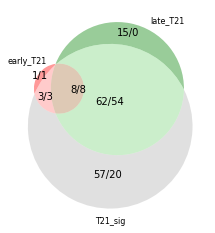

In [217]:
a = set(df2plot1['geneSym'].tolist()) #early_T21
b = set(df2plot2['geneSym'].tolist()) #late_T21
c = set(T21sig_genes['geneSym'].tolist()) #T21sig

genes_union = pd.concat([df2plot1,df2plot2,T21sig_genes], axis=0)[['geneSym','chr']].drop_duplicates().set_index('geneSym')
print(f'genes_union: {len(genes_union)}')

v3 = venn3([a, b, c], set_labels=('early_T21', 'late_T21', 'T21_sig'), set_colors=('r', 'g', '0.7'))
for text in v3.set_labels:
    text.set_fontsize(8)
sections = getVennGenesInChr21(v3, genes_union)
plt.savefig('figures/venn_sigup_genes.pdf', dpi=300)
plt.show()

In [218]:
print(len(sections['100']))
print(sections['100'])

1
['RCAN1']


In [219]:
print(len(sections['010']))
union_sigup_unique[union_sigup_unique['geneSym'].isin(sections['010'])].sort_values('logFC', ascending=False)[['geneSym','chr']]['geneSym'].tolist()

15


['MT1H',
 'RDH12',
 'NQO1',
 'TSPAN1',
 'FRMPD2',
 'CIB4',
 'C19orf33',
 'SH3BP5',
 'MC1R',
 'SULT1A2',
 'MT1X',
 'NMB',
 'OTOS',
 'SDSL',
 'WARS']

In [220]:
N=15
print(len(sections['001']))
union_sigup_unique[union_sigup_unique['geneSym'].isin(sections['001'])].sort_values('logFC', ascending=False)[['geneSym','chr']].head(N)['geneSym'].tolist()

57


['AMH',
 'AGMO',
 'PRR9',
 'ULBP1',
 'KRTAP10-4',
 'CES3',
 'LCA5L',
 'COL18A1',
 'NPDC1',
 'HSF2BP',
 'NOL3',
 'MAP3K7CL',
 'C2CD2',
 'BACE2',
 'C21orf58']

In [221]:
union_sigup_unique[union_sigup_unique['geneSym'].isin(sections['001'])].sort_values('logFC', ascending=False)[['geneSym','chr']].to_csv('./results/T21_time_insensitive_unique_genes.csv', index=False)

## Dn regulated genes

In [222]:
fname = '../data/allGenes_log2FC_splitbyCT.byAgeGroup.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

sig_genes = df[(df['logFC'] < -logFC_THRESH) & (df['FDR'] < FDR_THRESH)] #upregulated only
df2plot1 = sig_genes[sig_genes['comparison'].isin(['fTFC1_11_13','fTFC2_11_13'])] #celltype
print(f'{df2plot1.shape[0]} significant genes')

df2plot2 = sig_genes[sig_genes['comparison'].isin(['fTFC1_14_20','fTFC2_14_20'])] #celltype
print(f'{df2plot2.shape[0]} significant genes')

# time insensitive analysis
fname = '../data/allGenes_log2FC_splitbyCT.csv'
T21df = pd.read_csv(fname)
T21sig_genes = T21df[(T21df['logFC'] < -logFC_THRESH) & (T21df['FDR'] < FDR_THRESH)] #upregulated only
print(f'{T21sig_genes.shape[0]} significant genes')

49229 total genes
0 significant genes
29 significant genes
28 significant genes


genes_union: 46


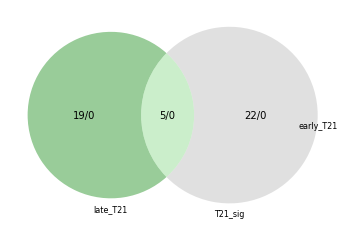

In [223]:
a = set(df2plot1['geneSym'].tolist()) #early_T21
b = set(df2plot2['geneSym'].tolist()) #late_T21
c = set(T21sig_genes['geneSym'].tolist()) #T21sig

genes_union = pd.concat([df2plot1,df2plot2,T21sig_genes], axis=0)[['geneSym','chr']].drop_duplicates().set_index('geneSym')
print(f'genes_union: {len(genes_union)}')

v3 = venn3([a, b, c], set_labels=('early_T21', 'late_T21', 'T21_sig'), set_colors=('r', 'g', '0.7'))
for text in v3.set_labels:
    text.set_fontsize(8)
sections = getVennGenesInChr21(v3, genes_union)
plt.savefig('figures/venn_sigdn_genes.pdf', dpi=300)
plt.show()

In [225]:
print(len(sections['010']))
union_sigdn_unique[union_sigdn_unique['geneSym'].isin(sections['010'])].sort_values('logFC', ascending=False)[['geneSym','chr']]['geneSym'].tolist()

19


['NOP53',
 'CMTM7',
 'PALM2-AKAP2',
 'MAP3K20',
 'FSTL1',
 'IL17D',
 'TENM3',
 'MFGE8',
 'CITED4',
 'CROCC',
 'SORCS1',
 'TOX2',
 'SLC43A3',
 'SERPINE2',
 'ADGRB3',
 'FGF2',
 'PROS1',
 'RUNX1T1',
 'IGFBP3']

In [226]:
N=22
print(len(sections['001']))
union_sigdn_unique[union_sigdn_unique['geneSym'].isin(sections['001'])].sort_values('logFC', ascending=False)[['geneSym','chr']].head(N)['geneSym'].tolist()

22


['COPS2',
 'DYRK1B',
 'PIAS3',
 'SLC36A4',
 'RCAN2',
 'PSMD5',
 'LBR',
 'BICC1',
 'ILF2',
 'COPS6',
 'SNCA',
 'FAM110A',
 'SMTNL2',
 'AHCY',
 'REC8',
 'RAB32',
 'TGFB2',
 'NKIRAS1',
 'CNTNAP2',
 'HIST1H1E',
 'ENPP2',
 'HIST1H1D']

In [6]:
def sortChr(ser, rm = None):
# sortChr(dat['chr'], rm=[1,'X'])
    df = pd.DataFrame()
    df['chr'] = ser
    df['chrNum'] = ser.str.extract(r'chr(\w+)')[0] 
    dig = df['chrNum'].str.extract(r'(\d+)')[0].dropna().astype(int)
    ch  = df['chrNum'].str.extract(r'([A-Z]+)')[0].dropna()
    output = pd.concat([dig.sort_values(), ch], axis=0)
    if rm:
        output = output[~output.isin(rm)] 
    return output

In [7]:
logFC_THRESH = 0.2
FDR_THRESH = 0.05

24479 total genes
186 significant genes
[INFO] coding genes found in adata 17464 (19394 total protein-coding genes)
[INFO] 1 aggs using ['celltype'] at min_cells=20,  min_pct=0.1. 7723 genes
[INFO] 1 aggs using ['celltype'] at min_cells=20,  min_pct=0.1. 9659 genes


Text(0.5, 0, '')

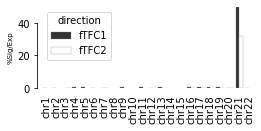

In [12]:
fname = '../data/allGenes_log2FC_splitbyCT.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

sig_genes = df[(df['logFC'] > logFC_THRESH) & (df['FDR'] < FDR_THRESH)] #upregulated only
df2plot = sig_genes[sig_genes['comparison'].isin(['fTFC1','fTFC2'])] #celltype
print(f'{len(df2plot)} significant genes')

significant_count_1 = df2plot[(df2plot['logFC']>0) & (sig_genes['comparison'] == 'fTFC1')].groupby(['chr'])['chr'].count().rename('sig_counts')
significant_count_2 = df2plot[(df2plot['logFC']>0) & (sig_genes['comparison'] == 'fTFC2')].groupby(['chr'])['chr'].count().rename('sig_counts')
filter_adata = adata[:, sf.getProteinCodingGenes(adata)]
filter_adata.var = sf.addChrInfo(filter_adata.var)
adata_L = filter_adata[filter_adata.obs['celltype'].isin(['thy_Lumen-forming'])]
HI_GENES_L, _ = sf.getExpPercGroup(adata_L, ['celltype'], min_cells=20, min_pct=0.1)
adata_P = filter_adata[filter_adata.obs['celltype'].isin(['thy_TH_processing'])]
HI_GENES_P, _ = sf.getExpPercGroup(adata_P, ['celltype'], min_cells=20, min_pct=0.1)
tmpL = adata_L.var.groupby(['chr'])['chr'].count().rename('exp_counts')
tmpP = adata_P.var.groupby(['chr'])['chr'].count().rename('exp_counts')
df_cat_1 = pd.concat([tmpP[tmpP.index.str.startswith('chr')],significant_count_1[significant_count_1.index.str.startswith('chr')]], axis=1)
df_cat_2 = pd.concat([tmpL[tmpL.index.str.startswith('chr')],significant_count_2[significant_count_2.index.str.startswith('chr')]], axis=1)
df_cat_1 = df_cat_1.iloc[sortChr(df_cat_1.index, rm=['X','Y','M']).index]
df_cat_2 = df_cat_2.iloc[sortChr(df_cat_2.index, rm=['X','Y','M']).index]
df_cat_1['direction'] = 'fTFC1'
df_cat_2['direction'] = 'fTFC2'
df_cat = pd.concat([df_cat_1,df_cat_2], axis=0)
df_cat['percent'] = df_cat['sig_counts']/df_cat['exp_counts'] * 100

# plot
fig, ax1 = plt.subplots(1,1, figsize=(3.8,1.5))
bar_ax = sns.barplot(data=df_cat.reset_index(), x='chr', y='percent', hue='direction', palette=['0.2', 'w'], ax=ax1, edgecolor='0.5', lw=0.3, zorder=3)
ax1.set_ylim(0, np.ceil(df_cat['percent'].max()))

sns.despine(ax=ax1, top=True, right=True, left=False, bottom=True, offset=5, trim=True)
ax1.tick_params(bottom=False)
ax1.set_xlabel('', fontsize=7)
ax1.set_ylabel('%Sig/Exp', fontsize=7)
ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=90, fontsize=10);
ax1.set_xlabel('', fontsize=7)

# Heatmap

In [49]:
import marsilea as ma
import marsilea.plotter as mp
from marsilea.layers import LayersMesh, Rect
import matplotlib.colors as colors
# from legendkit import cat_legend

In [50]:
FDR_THRESH = 1
print(FDR_THRESH)

1


In [51]:
fname = '../data/allGenes_log2FC_splitbyCT.csv'
df = pd.read_csv(fname)
print(f'{df.shape[0]} total genes')

24479 total genes


In [52]:
df = df.rename(columns={'comparison':'cell_type','geneSym':'gene'}).set_index('gene')

In [53]:
catmat = df

In [54]:
# get genes
TH_core_genes = ['NKX2-1','FOXE1' ,'HHEX','DIO2','DUOXA1','DUOXA2','DUOX1','DUOX2','SLC5A5','ANO1','SLC26A4','TSHR','TPO','IYD','TG','PAX8','GLIS3','SLC16A2','SLC16A10']
glut_genes = sf.read_tsvKEGG('/nfs/team292/hm11/endo_GLND/starsolo/data/pathways/KEGG_GLUTATHIONE_METABOLISM.v2023.2.Hs.tsv')
tight_gene = sf.read_tsvKEGG('/nfs/team292/hm11/endo_GLND/starsolo/data/pathways/KEGG_TIGHT_JUNCTION.v2023.2.Hs.tsv')
mt_genes = catmat.loc[catmat.index.str.contains('^MT\d')].index.tolist()

gg = {
#       'Metallothionein'  : mt_genes + ['SCNN1A'],
#       'Hypoxia' : ['HYOU1','IPCEF1','SOD1','SOD3', 'CYBA', 'IPCEF1', 'NQO1', 'PGD'],
#       'Epithelial apical junction' : ['PATJ','PRKCI','DLG2','DLG5','EZR','PARD3B'],
#     'Glutathione': glut_genes, 
      'TH core' : TH_core_genes,
#       'tight' :tight_gene,
#       'Tight Junction' : ['CLDN1','CLDN5','CLDN4','CLDN8','CLDN3','OCLN','EXOC3','EXOC4','TJP1','MAGI1','CXADR','CDC42','FGD4'],
      'Tight Junction' : ['AJM1', 'APP', 'CHAF1B', 'CXADR', 'DSP'],
#       'Sound related genes' : ['PKHD1L1','TSPEAR']
     }
gg_values = sum(gg.values(), [])

# subset df
df = catmat[['logFC','cell_type','FDR']].loc[(catmat.index.isin(gg_values))]

# get FDR to annotate 
df2annot = df.pivot_table(index=['gene'], columns=['cell_type'], values='FDR')
# df2annot.columns = df2annot.columns.map('|'.join).str.strip('|')
df2annot = df2annot[(df2annot <= FDR_THRESH).any(axis=1)]

# perp logFC to plot
df2plot = df.loc[df2annot.index].pivot_table(index=['gene'], columns=['cell_type'], values='logFC')
# Age = pd.Series(df2plot.columns.get_level_values('age_group'))
Cell_type = pd.Series(df2plot.columns.get_level_values('cell_type'))
# df2plot.columns = df2plot.columns.map('|'.join).str.strip('|')
# Age.index = df2plot.columns
Cell_type.index = df2plot.columns

# add gene info to df2plot
reversed_dict = {}
for key, value in gg.items():
    for v in value:
        reversed_dict[v] = key
df2plot = pd.concat([df2plot.reset_index(),df2plot.reset_index()['gene'].map(reversed_dict).rename('gene_fam')], axis=1).set_index('gene')

# add chr21 labels
df2plot = sf.addChrInfo(df2plot, mark='chr21')

In [55]:
df2plot

,fTFC1,fTFC2,gene_fam,chr,ensID
gene,,,,,
AJM1,0.428684,0.388051,Tight Junction,other,ENSG00000232434
ANO1,0.430419,0.439440,TH core,other,ENSG00000131620
APP,0.603826,0.539766,Tight Junction,chr21,ENSG00000142192
CHAF1B,0.616146,0.631285,Tight Junction,chr21,ENSG00000159259
CXADR,0.575858,0.572399,Tight Junction,chr21,ENSG00000154639
DIO2,0.164717,0.126727,TH core,other,ENSG00000211448
DSP,0.418957,0.316172,Tight Junction,other,ENSG00000096696
DUOX1,0.080957,-0.044869,TH core,other,ENSG00000137857
DUOX2,0.143708,0.154095,TH core,other,ENSG00000140279
